In [9]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics

In [10]:
data = pd.read_csv("train.csv")

C:\Users\gpbuser\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (135,204,274,417) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
data.shape

(105471, 771)

In [12]:
data.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f770,f771,f772,f773,f774,f775,f776,f777,f778,loss
0,1,126,10,0.686842,1100,3,13699,7201.0,4949.0,126.75,...,5,2.14,-1.54,1.18,0.1833,0.7873,1,0,5,0
1,2,121,10,0.782776,1100,3,84645,240.0,1625.0,123.52,...,6,0.54,-0.24,0.13,0.1926,-0.6787,1,0,5,0
2,3,126,10,0.500080,1100,3,83607,1800.0,1527.0,127.76,...,13,2.89,-1.73,1.04,0.2521,0.7258,1,0,5,0
3,4,134,10,0.439874,1100,3,82642,7542.0,1730.0,132.94,...,4,1.29,-0.89,0.66,0.2498,0.7119,1,0,5,0
4,5,109,9,0.502749,2900,4,79124,89.0,491.0,122.72,...,26,6.11,-3.82,2.51,0.2282,-0.5399,0,0,5,0


In [13]:
target = 'loss'
y_col =  ['loss']

In [16]:
data[target].value_counts()

0    95688
1     9783
Name: loss, dtype: int64

In [15]:
set(data.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

In [16]:
num_features = [x for x in data.columns if data[x].dtype!='object']
cat_features = [x for x in data.columns if data[x].dtype=='object']

In [30]:
for feature in cat_features:        
    data[feature] = [float(x) if x!='NA' else 0. for x in data[feature]]

In [31]:
X_col = num_features + cat_features

X_train, X_test, y_train, y_test = train_test_split(data, data[y_col], 
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=data[y_col])

In [32]:
y_train[target].mean()

0.09275487951888824

In [33]:
y_test[target].mean()

0.09275646292901839

In [34]:
for feature in X_col: 
        X_train[feature] = X_train[feature].fillna(0.)
        X_test[feature]  = X_test[feature].fillna(0.)        

In [36]:
X_col.remove(target)

In [37]:
model = CatBoostClassifier(eval_metric='AUC',
                           cat_features=[],
                           verbose=100)
model.fit(X_train[X_col], y_train[y_col],
          eval_set=(X_test[X_col], y_test[y_col]))
y_pred = model.predict_proba(X_test[X_col])[:,1]

Learning rate set to 0.091698
0:	test: 0.5902409	best: 0.5902409 (0)	total: 303ms	remaining: 5m 2s
100:	test: 0.7140797	best: 0.7140797 (100)	total: 18.6s	remaining: 2m 45s
200:	test: 0.7223253	best: 0.7225313 (186)	total: 38.6s	remaining: 2m 33s
300:	test: 0.7236169	best: 0.7237004 (279)	total: 57.5s	remaining: 2m 13s
400:	test: 0.7239309	best: 0.7240722 (386)	total: 1m 16s	remaining: 1m 54s
500:	test: 0.7234797	best: 0.7240722 (386)	total: 1m 35s	remaining: 1m 34s
600:	test: 0.7236242	best: 0.7240722 (386)	total: 1m 54s	remaining: 1m 15s
700:	test: 0.7226374	best: 0.7240722 (386)	total: 2m 13s	remaining: 56.9s
800:	test: 0.7217749	best: 0.7240722 (386)	total: 2m 32s	remaining: 37.8s
900:	test: 0.7209602	best: 0.7240722 (386)	total: 2m 51s	remaining: 18.8s
999:	test: 0.7196609	best: 0.7240722 (386)	total: 3m 11s	remaining: 0us

bestTest = 0.7240722499
bestIteration = 386

Shrink model to first 387 iterations.


In [38]:
fi = pd.DataFrame({'feature': X_col, 'fi': model.feature_importances_})
t_fi = fi[fi['fi']!=0].sort_values('fi', ascending=False).head(30)

In [39]:
t_fi

,feature,fi
648,f674,6.820799
2,f2,3.709952
65,f67,2.642163
455,f471,2.131331
738,f766,1.487153
644,f670,1.309200
575,f596,1.053183
324,f332,1.042134
449,f464,1.015953
495,f514,0.870787


Text(0.5, 0, 'Feature importances')

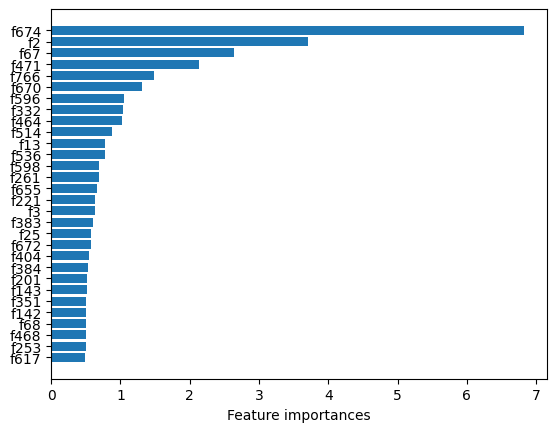

In [49]:
fig, ax = plt.subplots()
ax.barh(t_fi['feature'], t_fi['fi'])
ax.invert_yaxis()
ax.set_xlabel("Feature importances")

In [50]:
top30 = list(t_fi['feature'])

In [78]:
def get_scor_cv(X_col, data):
    for feature in X_col:
        data[feature] = data[feature].fillna(0.)
    data_pool = Pool(data=data[X_col], label=data[y_col], cat_features=[])
    params = {'cat_features': [],
              'eval_metric': 'AUC',
              'loss_function': 'Logloss',
              'random_seed': 42,
              'verbose': 100,              
              }
    cv_data = cv(params=params,
                 pool=data_pool,
                 fold_count=3,
                 shuffle=True,
                 partition_random_seed=42,
                 stratified=True,
                 early_stopping_rounds=200
                 )
    return list(cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]['test-AUC-mean'])[0]

In [79]:
data_sample = data[::10].copy(deep=True)

In [80]:
data_sample.shape

(10548, 771)

In [81]:
scor = get_scor_cv(X_col, data_sample)

Training on fold [0/3]
0:	test: 0.5909488	best: 0.5909488 (0)	total: 190ms	remaining: 3m 9s
100:	test: 0.6691669	best: 0.6699613 (93)	total: 11.3s	remaining: 1m 40s
200:	test: 0.6736446	best: 0.6738529 (195)	total: 22.4s	remaining: 1m 29s
300:	test: 0.6800613	best: 0.6806742 (272)	total: 35.2s	remaining: 1m 21s
400:	test: 0.6811453	best: 0.6817691 (385)	total: 47.6s	remaining: 1m 11s
500:	test: 0.6859345	best: 0.6863480 (495)	total: 1m 3s	remaining: 1m 2s
600:	test: 0.6876145	best: 0.6884892 (576)	total: 1m 17s	remaining: 51.4s
700:	test: 0.6868181	best: 0.6884892 (576)	total: 1m 31s	remaining: 38.8s

bestTest = 0.6884892122
bestIteration = 576

Training on fold [1/3]
0:	test: 0.5887892	best: 0.5887892 (0)	total: 114ms	remaining: 1m 53s
100:	test: 0.7038297	best: 0.7049424 (96)	total: 13.7s	remaining: 2m 2s
200:	test: 0.7071986	best: 0.7079058 (196)	total: 25.3s	remaining: 1m 40s
300:	test: 0.7088350	best: 0.7094588 (292)	total: 35.8s	remaining: 1m 23s
400:	test: 0.7099071	best: 0.7103

In [82]:
scor

0.692808960162912

In [83]:
X_col_fs = []
scores = []

for i in range(len(top30)):
    X_col_fs.append(top30[i])
    new_best_score = get_scor_cv(X_col_fs, data_sample)
    scores.append(new_best_score)
    print(i+1, '/', len(top30))

Training on fold [0/3]
0:	test: 0.5430163	best: 0.5430163 (0)	total: 5.69ms	remaining: 5.68s


100:	test: 0.5586845	best: 0.5614079 (39)	total: 845ms	remaining: 7.52s
200:	test: 0.5572346	best: 0.5623124 (138)	total: 1.42s	remaining: 5.63s
300:	test: 0.5612304	best: 0.5623124 (138)	total: 1.96s	remaining: 4.54s
400:	test: 0.5624056	best: 0.5633983 (337)	total: 2.55s	remaining: 3.81s
500:	test: 0.5611034	best: 0.5633983 (337)	total: 3.11s	remaining: 3.1s

bestTest = 0.5633983428
bestIteration = 337

Training on fold [1/3]
0:	test: 0.5382232	best: 0.5382232 (0)	total: 4.56ms	remaining: 4.56s
100:	test: 0.5508973	best: 0.5565081 (54)	total: 539ms	remaining: 4.79s
200:	test: 0.5507366	best: 0.5565081 (54)	total: 1.15s	remaining: 4.59s

bestTest = 0.5565081349
bestIteration = 54

Training on fold [2/3]
0:	test: 0.5290157	best: 0.5290157 (0)	total: 14ms	remaining: 14s
100:	test: 0.5463714	best: 0.5484888 (13)	total: 581ms	remaining: 5.17s
200:	test: 0.5494865	best: 0.5501123 (158)	total: 1.13s	remaining: 4.48s
300:	test: 0.5513371	best: 0.5519441 (286)	total: 1.68s	remaining: 3.9s
400

In [84]:
scores

[0.5547758719580025,
 0.5779412518244132,
 0.6039370963769589,
 0.6146672088252845,
 0.6720158548337243,
 0.6757461705915314,
 0.6674894915444742,
 0.6770261938646819,
 0.6881130070133507,
 0.6882485466677907,
 0.6851043572693057,
 0.6888194661390538,
 0.6859255292244982,
 0.6900842825241451,
 0.68848458401723,
 0.6925831709336864,
 0.6920443181611566,
 0.6939015420115077,
 0.6915801774908305,
 0.6933732679437147,
 0.6919874576231965,
 0.6946347784835757,
 0.6952245412726512,
 0.6957505012487829,
 0.6932717784951462,
 0.690896198112693,
 0.693431120235244,
 0.6926241634145415,
 0.7001310767633792,
 0.7029681531399744]

<AxesSubplot:>

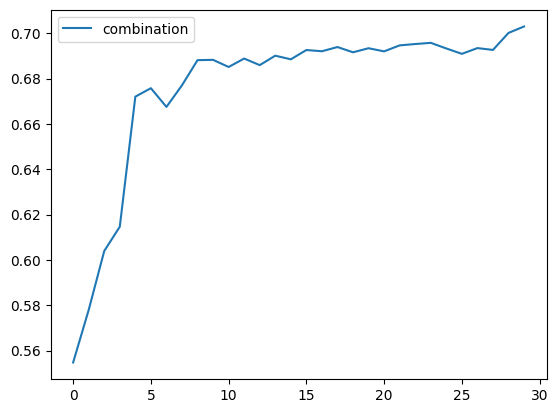

In [89]:
t_comb = pd.DataFrame(scores, columns=['combination'])
t_comb.plot()


In [92]:
t_comb[:9]

,combination
0,0.554776
1,0.577941
2,0.603937
3,0.614667
4,0.672016
5,0.675746
6,0.667489
7,0.677026
8,0.688113


In [93]:
top9 = top30[:9]

In [94]:
top9

['f674', 'f2', 'f67', 'f471', 'f766', 'f670', 'f596', 'f332', 'f464']

In [111]:
data[top9].head()

,f674,f2,f67,f471,f766,f670,f596,f332,f464
0,33,10,4.5785,1.17,-0.560,335,2.430,745.57,2264988.75
1,43,10,4.5785,1.20,-0.275,335,2.430,42.00,32113.02
2,100,10,4.5785,1.17,-0.540,335,2.430,47.49,246757.94
3,18,10,4.5785,1.13,-0.635,335,2.430,687.25,3525883.45
4,33,9,4.9649,1.24,-0.280,381,2.845,28.26,4882.19


In [116]:
data[top9].dtypes

f674      int64
f2        int64
f67     float64
f471    float64
f766    float64
f670      int64
f596    float64
f332    float64
f464    float64
dtype: object

In [114]:
for feature in top9:
    print(feature, data[feature].min(), data[feature].max(), data[feature].median())

f674 3 222 24.0
f2 1 11 9.0
f67 0.0 26.3747 7.8278
f471 0.0 50.63 1.16
f766 -0.95 0.0 -0.48
f670 0 5872 708.0
f596 0.1 18.375 5.525
f332 0.0 1078829.63 302.24
f464 0.0 19120101.05 471648.22


In [95]:
get_scor_cv(top9, data)

Training on fold [0/3]
0:	test: 0.6366236	best: 0.6366236 (0)	total: 26ms	remaining: 25.9s
100:	test: 0.6948079	best: 0.6948079 (100)	total: 2.56s	remaining: 22.8s
200:	test: 0.7000661	best: 0.7000661 (200)	total: 4.77s	remaining: 19s
300:	test: 0.7022886	best: 0.7022996 (293)	total: 6.92s	remaining: 16.1s
400:	test: 0.7030161	best: 0.7032185 (380)	total: 9.1s	remaining: 13.6s
500:	test: 0.7033685	best: 0.7035137 (441)	total: 11.3s	remaining: 11.2s
600:	test: 0.7027732	best: 0.7035137 (441)	total: 13.5s	remaining: 8.96s

bestTest = 0.7035136983
bestIteration = 441

Training on fold [1/3]
0:	test: 0.6339013	best: 0.6339013 (0)	total: 17.2ms	remaining: 17.2s
100:	test: 0.6856465	best: 0.6856465 (100)	total: 2.61s	remaining: 23.2s
200:	test: 0.6894424	best: 0.6894578 (198)	total: 4.81s	remaining: 19.1s
300:	test: 0.6913747	best: 0.6913982 (298)	total: 7.32s	remaining: 17s
400:	test: 0.6925582	best: 0.6925582 (400)	total: 9.71s	remaining: 14.5s
500:	test: 0.6936913	best: 0.6937432 (494)	to

0.6959103561839188

In [96]:
# 0.6959103561839188

In [108]:
model = CatBoostClassifier(eval_metric='AUC',
                           cat_features=[],
                           verbose=100)
model.fit(X_train[top9], y_train[y_col],
          eval_set=(X_test[top9], y_test[y_col]))
y_pred = model.predict_proba(X_test[top9])[:,1]

Learning rate set to 0.091698
0:	test: 0.6125411	best: 0.6125411 (0)	total: 25.4ms	remaining: 25.3s
100:	test: 0.6930049	best: 0.6931301 (91)	total: 1.93s	remaining: 17.2s
200:	test: 0.6921937	best: 0.6943277 (128)	total: 4.47s	remaining: 17.8s
300:	test: 0.6898390	best: 0.6943277 (128)	total: 7.31s	remaining: 17s
400:	test: 0.6882183	best: 0.6943277 (128)	total: 9.88s	remaining: 14.8s
500:	test: 0.6853430	best: 0.6943277 (128)	total: 12.1s	remaining: 12.1s
600:	test: 0.6830608	best: 0.6943277 (128)	total: 14.5s	remaining: 9.66s
700:	test: 0.6809568	best: 0.6943277 (128)	total: 17s	remaining: 7.26s
800:	test: 0.6791330	best: 0.6943277 (128)	total: 19.6s	remaining: 4.87s
900:	test: 0.6774411	best: 0.6943277 (128)	total: 21.9s	remaining: 2.41s
999:	test: 0.6752350	best: 0.6943277 (128)	total: 24.1s	remaining: 0us

bestTest = 0.6943277284
bestIteration = 128

Shrink model to first 129 iterations.


In [109]:
with open("model_pickle.pkl", 'wb') as f:
    pickle.dump(model, f)

In [110]:
metrics.roc_auc_score(y_test[y_col], y_pred)

0.6943277283870657

In [118]:
X_test['loss']=y_test

In [119]:
X_test

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f770,f771,f772,f773,f774,f775,f776,f777,f778,loss
41822,41823,154,8,0.631471,3700,10,13970,2033.0,3767.0,153.00,...,3,1.34,-0.97,0.72,0.1688,0.7840,1,1,24,0
47964,47965,120,10,0.347412,1100,16,842,1193.0,565.0,124.42,...,9,2.14,-1.32,0.88,0.2381,0.5881,0,0,394,0
97613,97614,133,9,0.765413,1300,3,77825,105.0,496.0,126.38,...,16,4.41,-3.42,2.87,0.3167,-0.7676,0,0,19,0
49721,49722,140,9,0.971501,3100,16,78935,4773.0,85.0,143.24,...,19,5.84,-4.42,3.59,0.3187,-0.3194,0,0,1083,0
16333,16334,113,6,0.622908,1100,3,78223,1696.0,7530.0,122.51,...,34,11.85,-8.23,6.00,0.2145,0.2993,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60639,60640,126,10,0.095628,1900,16,83607,2802.0,397.0,125.90,...,31,9.86,-7.09,5.48,0.2711,0.4024,0,0,513,0
78598,78599,119,10,0.968532,1100,16,3793,43.0,797.0,117.45,...,16,3.08,-1.80,1.14,0.2138,-0.7242,1,0,513,0
9127,9128,127,8,0.612080,1800,7,13699,4132.0,5065.0,125.92,...,9,2.88,-2.09,1.63,0.2827,0.5033,0,0,23,0
83863,83864,123,9,0.196581,3100,4,8141,314.0,1640.0,127.25,...,9,2.38,-1.64,1.23,0.2606,-0.6458,0,0,23,0


In [120]:
X_test.to_csv('test.csv', index=False)